In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(-2), float(2), int(50))
# The original sin/cos data
#one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.02)

# Polynomials + diff(poly) data
#one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
#two = int(3)*torch.pow(train_x, int(2)) + torch.randn(train_x.size()) * float(0.2)

# Polynomials + diff(poly) data
one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
two = int(3)*train_x**int(2) + torch.randn(train_x.size()) * float(0.2)

# Combined poly + sin/cos
#one = torch.mul(torch.sin(train_x), train_x)+ torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), train_x) + torch.sin(train_x) + torch.randn(train_x.size()) * float(0.2)

# only sin/cos
#one = torch.mul(torch.sin(train_x), torch.cos(train_x)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), torch.cos(train_x)) - torch.mul(torch.sin(train_x), torch.sin(train_x)) + torch.randn(train_x.size()) * float(0.2)

train_y = torch.stack([one,two], int(-1))
#train_y = torch.stack([one, two], int(-1))


In [3]:
print(train_x)
print(train_y)
print(np.shape(train_y))

# = torch.Tensor([[float(-0.3), float(0.99)],[float(-0.07), float(1.01)]])

tensor([-2.0000, -1.9184, -1.8367, -1.7551, -1.6735, -1.5918, -1.5102, -1.4286,
        -1.3469, -1.2653, -1.1837, -1.1020, -1.0204, -0.9388, -0.8571, -0.7755,
        -0.6939, -0.6122, -0.5306, -0.4490, -0.3673, -0.2857, -0.2041, -0.1224,
        -0.0408,  0.0408,  0.1224,  0.2041,  0.2857,  0.3673,  0.4490,  0.5306,
         0.6122,  0.6939,  0.7755,  0.8571,  0.9388,  1.0204,  1.1020,  1.1837,
         1.2653,  1.3469,  1.4286,  1.5102,  1.5918,  1.6735,  1.7551,  1.8367,
         1.9184,  2.0000])
tensor([[-7.8799e+00,  1.2069e+01],
        [-7.2068e+00,  1.0774e+01],
        [-6.0574e+00,  1.0233e+01],
        [-5.6471e+00,  9.3111e+00],
        [-4.7026e+00,  8.4038e+00],
        [-4.0020e+00,  7.6815e+00],
        [-3.6166e+00,  6.8767e+00],
        [-2.6558e+00,  6.4452e+00],
        [-2.4851e+00,  4.9195e+00],
        [-1.9903e+00,  4.7453e+00],
        [-1.7342e+00,  3.9630e+00],
        [-1.3075e+00,  3.9953e+00],
        [-6.4264e-01,  3.1634e+00],
        [-9.3964e-01,  2.

In [4]:

len(train_y.shape)

2

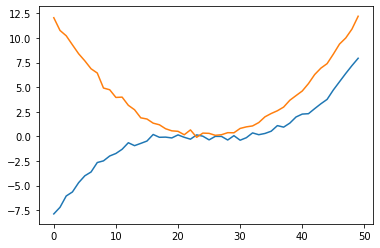

In [5]:
plt.plot(train_y)

$$
\begin{align}
L =& 
\left[
\begin{matrix}
1 & dx_1 \\
0 & 1
\end{matrix}
\right]\\
R =& 
\left[
\begin{matrix}
1 & 0\\
dx_2 & 1
\end{matrix}
\right]\\
\hat{k} =& 
\left[
\begin{matrix}
SE_1 & 0\\
0 & SE_2
\end{matrix}
\right]\\
k =& L*\hat{k}*R\\
=& \left[
\begin{matrix}
dx_1 dx_2 SE_2 + SE_1 & dx_1 SE_2\\
dx_2 SE_2 & SE_2
\end{matrix}
\right]
\end{align}
$$

In [6]:
dx1, dx2, k1, k2, f, g = var('dx1, dx2, k1, k2, f, g')
K = matrix(2,2, (k1, 0, 0, 0))
L = matrix(2, 2, (1, 0, dx1^2, 1))
R = matrix(2, 2, (1, dx2^2, 0, 1))
L*K*R
# used to see how the data should be created if I 
# decide to create it exactly as I create the kernel
#K = matrix(2,1, (f, g))
#L*L*K

[            k1       dx2^2*k1]
[      dx1^2*k1 dx1^2*dx2^2*k1]

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        kernel = Diff_SE_kernel(var=0, length=0)
        kernel2 = Diff_SE_kernel(var=0, length=0)
        q, dx1, dx2 = var('q, dx1, dx2')
        L = matrix(2, 2, (1, 0, dx1, 1))
        R = matrix(2, 2, (1, dx2, 0, 1))
        p = DiffMatrixKernel([[kernel, None], [None, None]])
        self.covar_module = p.diff(left_matrix=L, right_matrix=R)
        
        #kernel0 = gpytorch.kernels.RBFKernel()
        #kernel1 = gpytorch.kernels.RBFKernel()
        #kernel2 = gpytorch.kernels.RBFKernel()
        #kernel0 = gpytorch.kernels.PeriodicKernel()
        #kernel1 = gpytorch.kernels.PeriodicKernel()
        #kernel0 = Diff_SE_kernel(var = 0, length=0)
        #kernel1 = Diff_SE_kernel(var = 0, length=0.01)
        #kernel2 = Diff_SE_kernel(var = 0, length=0.02)
        #self.covar_module = MatrixKernel([[kernel0, None], [None, kernel1]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, has_global_noise=False, has_task_noise=False)
likelihood._set_task_noises(torch.Tensor([float(0.0001),float(0.0001)]))
#likelihood._set_noise(torch.tensor(float(0.0001)))
model = MultitaskGPModel(train_x, train_y, likelihood)

List of all kernels: [Diff_SE_kernel()]
List of all kernels: [RBFKernel(
  (raw_lengthscale_constraint): Positive()
), RBFKernel(
  (raw_lengthscale_constraint): Positive()
)]


In [8]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(75)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

param_dict = {p[0]:[] for p in model.named_parameters() if 'covar' in p[0]}
param_dict['loss'] = []
param_dict['noise'] = []
if len(likelihood.task_noises) > 1:
    param_dict['task_noises'] = [[] for i in range(len(likelihood.task_noises))]
for p in model.named_parameters():
    if 'covar' in p[0]:
        param_dict[f"{p[0]}_grad"] = []

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    param_dict['loss'].append(loss.item())
    #pdb.set_trace()
    loss.backward()
    for parameter in model.named_parameters():
        if 'covar' in parameter[0]:
            param_dict[parameter[0]].append(parameter[1].item())
            #param_dict[f"{parameter[0]}_grad"].append(parameter[1].grad.item())
    param_dict['noise'].append(likelihood.noise.item())
    for l in range(len(likelihood.task_noises)):
        param_dict['task_noises'][l].append(likelihood.task_noises[l].item())
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

tensor([[1.0000e+00, 0.0000e+00, 9.9309e-01,  ..., 0.0000e+00, 5.8693e-08,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.1501e-07, 0.0000e+00,
         5.8693e-08],
        [9.9309e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.1501e-07,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.1501e-07, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9309e-01],
        [5.8693e-08, 0.0000e+00, 1.1501e-07,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 5.8693e-08, 0.0000e+00,  ..., 9.9309e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.9278e+01,  0.0000e+00],
        [ 1.9278e+01,  0.0000e+00],
        [ 1.4352e+01,  0.0000e+00],
        [ 1.4352e+01,  0.0000e+00],
        [ 4.5299e+00,  0.0000e+00],
        [ 8.8300e+00,  0.0000e+00],
        [ 8.8300e+00,  0.0000e+00],
        [ 1.9613e+00,  0.0000e+00],
        [ 4.5299e+00,  0.0000e+00],
        [ 1.9613e+00,

/Users/andreas/Documents/container_storage/sage/DiffEqGPs/kernels.py:617: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  print(result.eig())


tensor([[1.0000e+00, 0.0000e+00, 9.9201e-01,  ..., 0.0000e+00, 4.2957e-09,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 9.3554e-09, 0.0000e+00,
         4.2957e-09],
        [9.9201e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 9.3554e-09,
         0.0000e+00],
        ...,
        [0.0000e+00, 9.3554e-09, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9201e-01],
        [4.2957e-09, 0.0000e+00, 9.3554e-09,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 4.2957e-09, 0.0000e+00,  ..., 9.9201e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.8128e+01,  0.0000e+00],
        [ 1.8128e+01,  0.0000e+00],
        [ 1.3958e+01,  0.0000e+00],
        [ 1.3958e+01,  0.0000e+00],
        [ 5.0052e+00,  0.0000e+00],
        [ 9.0689e+00,  0.0000e+00],
        [ 9.0689e+00,  0.0000e+00],
        [ 2.3678e+00,  0.0000e+00],
        [ 5.0052e+00,  0.0000e+00],
        [ 9.7050e-01,

tensor([[1.0000e+00, 0.0000e+00, 9.8933e-01,  ..., 0.0000e+00, 6.4385e-12,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 3.1459e-10, 0.0000e+00,
         1.2523e-10],
        [9.8933e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.8235e-11,
         0.0000e+00],
        ...,
        [0.0000e+00, 3.1459e-10, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9055e-01],
        [6.4385e-12, 0.0000e+00, 1.8235e-11,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.2523e-10, 0.0000e+00,  ..., 9.9055e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.5979e+01,  0.0000e+00],
        [ 1.3026e+01,  0.0000e+00],
        [ 1.6859e+01,  0.0000e+00],
        [ 1.3438e+01,  0.0000e+00],
        [ 9.2892e+00,  0.0000e+00],
        [ 5.8152e+00,  0.0000e+00],
        [ 9.2371e+00,  0.0000e+00],
        [ 3.2117e+00,  0.0000e+00],
        [ 5.5009e+00,  0.0000e+00],
        [ 1.5745e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8614e-01,  ..., 0.0000e+00, 2.7640e-15,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 8.2676e-10, 0.0000e+00,
         3.4276e-10],
        [9.8614e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0708e-14,
         0.0000e+00],
        ...,
        [0.0000e+00, 8.2676e-10, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9096e-01],
        [2.7640e-15, 0.0000e+00, 1.0708e-14,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 3.4276e-10, 0.0000e+00,  ..., 9.9096e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.4207e+01,  0.0000e+00],
        [ 1.2074e+01,  0.0000e+00],
        [ 9.2187e+00,  0.0000e+00],
        [ 1.7193e+01,  0.0000e+00],
        [ 6.3362e+00,  0.0000e+00],
        [ 1.3584e+01,  0.0000e+00],
        [ 3.9314e+00,  0.0000e+00],
        [ 9.2032e+00,  0.0000e+00],
        [ 5.3746e+00,  0.0000e+00],
        [ 2.2099e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8326e-01,  ..., 0.0000e+00, 2.5290e-18,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 3.5791e-09, 0.0000e+00,
         1.5783e-09],
        [9.8326e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.2998e-17,
         0.0000e+00],
        ...,
        [0.0000e+00, 3.5791e-09, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9159e-01],
        [2.5290e-18, 0.0000e+00, 1.2998e-17,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.5783e-09, 0.0000e+00,  ..., 9.9159e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.7739e+01,  0.0000e+00],
        [ 1.3031e+01,  0.0000e+00],
        [ 1.1355e+01,  0.0000e+00],
        [ 1.3808e+01,  0.0000e+00],
        [ 9.0339e+00,  0.0000e+00],
        [ 6.5713e+00,  0.0000e+00],
        [ 9.1315e+00,  0.0000e+00],
        [ 4.3781e+00,  0.0000e+00],
        [ 2.6780e+00,  0.0000e+00],
        [ 5.1611e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8186e-01,  ..., 0.0000e+00, 8.2284e-20,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.3865e-09, 0.0000e+00,
         1.0346e-09],
        [9.8186e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 4.8566e-19,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.3865e-09, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9142e-01],
        [8.2284e-20, 0.0000e+00, 4.8566e-19,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.0346e-09, 0.0000e+00,  ..., 9.9142e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2553e+01,  0.0000e+00],
        [ 1.1043e+01,  0.0000e+00],
        [ 1.7583e+01,  0.0000e+00],
        [ 8.9260e+00,  0.0000e+00],
        [ 6.6359e+00,  0.0000e+00],
        [ 1.3746e+01,  0.0000e+00],
        [ 4.5445e+00,  0.0000e+00],
        [ 9.1540e+00,  0.0000e+00],
        [ 2.8725e+00,  0.0000e+00],
        [ 5.2230e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8207e-01,  ..., 0.0000e+00, 1.3785e-19,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 3.3198e-10, 0.0000e+00,
         1.3245e-10],
        [9.8207e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 7.9684e-19,
         0.0000e+00],
        ...,
        [0.0000e+00, 3.3198e-10, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9057e-01],
        [1.3785e-19, 0.0000e+00, 7.9684e-19,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.3245e-10, 0.0000e+00,  ..., 9.9057e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.6877e+01,  0.0000e+00],
        [ 1.2621e+01,  0.0000e+00],
        [ 1.1089e+01,  0.0000e+00],
        [ 8.9427e+00,  0.0000e+00],
        [ 1.3446e+01,  0.0000e+00],
        [ 6.6278e+00,  0.0000e+00],
        [ 4.5213e+00,  0.0000e+00],
        [ 9.2355e+00,  0.0000e+00],
        [ 2.8446e+00,  0.0000e+00],
        [ 5.4942e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8311e-01,  ..., 0.0000e+00, 1.7146e-18,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 4.9911e-11, 0.0000e+00,
         1.8386e-11],
        [9.8311e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 8.9517e-18,
         0.0000e+00],
        ...,
        [0.0000e+00, 4.9911e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8976e-01],
        [1.7146e-18, 0.0000e+00, 8.9517e-18,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.8386e-11, 0.0000e+00,  ..., 9.8976e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1318e+01,  0.0000e+00],
        [ 1.2974e+01,  0.0000e+00],
        [ 1.6274e+01,  0.0000e+00],
        [ 9.0220e+00,  0.0000e+00],
        [ 6.5800e+00,  0.0000e+00],
        [ 1.3169e+01,  0.0000e+00],
        [ 9.2779e+00,  0.0000e+00],
        [ 4.3985e+00,  0.0000e+00],
        [ 5.7132e+00,  0.0000e+00],
        [ 2.7012e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8403e-01,  ..., 0.0000e+00, 1.6327e-17,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 4.1599e-11, 0.0000e+00,
         1.5207e-11],
        [9.8403e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 7.7820e-17,
         0.0000e+00],
        ...,
        [0.0000e+00, 4.1599e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8968e-01],
        [1.6327e-17, 0.0000e+00, 7.7820e-17,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.5207e-11, 0.0000e+00,  ..., 9.8968e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.3315e+01,  0.0000e+00],
        [ 1.1535e+01,  0.0000e+00],
        [ 1.6219e+01,  0.0000e+00],
        [ 9.0890e+00,  0.0000e+00],
        [ 1.3143e+01,  0.0000e+00],
        [ 6.5239e+00,  0.0000e+00],
        [ 9.2805e+00,  0.0000e+00],
        [ 4.2743e+00,  0.0000e+00],
        [ 5.7323e+00,  0.0000e+00],
        [ 2.5629e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8417e-01,  ..., 0.0000e+00, 2.2794e-17,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 9.2116e-11, 0.0000e+00,
         3.4820e-11],
        [9.8417e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0719e-16,
         0.0000e+00],
        ...,
        [0.0000e+00, 9.2116e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9002e-01],
        [2.2794e-17, 0.0000e+00, 1.0719e-16,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 3.4820e-11, 0.0000e+00,  ..., 9.9002e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1568e+01,  0.0000e+00],
        [ 1.3368e+01,  0.0000e+00],
        [ 1.6462e+01,  0.0000e+00],
        [ 9.0986e+00,  0.0000e+00],
        [ 1.3258e+01,  0.0000e+00],
        [ 6.5144e+00,  0.0000e+00],
        [ 9.2675e+00,  0.0000e+00],
        [ 4.2547e+00,  0.0000e+00],
        [ 5.6464e+00,  0.0000e+00],
        [ 2.5415e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8324e-01,  ..., 0.0000e+00, 2.3685e-18,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 9.6890e-11, 0.0000e+00,
         3.6703e-11],
        [9.8324e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.2205e-17,
         0.0000e+00],
        ...,
        [0.0000e+00, 9.6890e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.9004e-01],
        [2.3685e-18, 0.0000e+00, 1.2205e-17,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 3.6703e-11, 0.0000e+00,  ..., 9.9004e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1348e+01,  0.0000e+00],
        [ 1.3021e+01,  0.0000e+00],
        [ 9.0319e+00,  0.0000e+00],
        [ 6.5728e+00,  0.0000e+00],
        [ 1.6478e+01,  0.0000e+00],
        [ 4.3816e+00,  0.0000e+00],
        [ 1.3265e+01,  0.0000e+00],
        [ 9.2665e+00,  0.0000e+00],
        [ 5.6407e+00,  0.0000e+00],
        [ 2.6820e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8137e-01,  ..., 0.0000e+00, 2.4750e-20,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.5346e-11, 0.0000e+00,
         9.0741e-12],
        [9.8137e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.5335e-19,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.5346e-11, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8947e-01],
        [2.4750e-20, 0.0000e+00, 1.5335e-19,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 9.0741e-12, 0.0000e+00,  ..., 9.8947e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2397e+01,  0.0000e+00],
        [ 1.0939e+01,  0.0000e+00],
        [ 8.8867e+00,  0.0000e+00],
        [ 1.6074e+01,  0.0000e+00],
        [ 6.6527e+00,  0.0000e+00],
        [ 4.5961e+00,  0.0000e+00],
        [ 1.3073e+01,  0.0000e+00],
        [ 9.2863e+00,  0.0000e+00],
        [ 5.7829e+00,  0.0000e+00],
        [ 2.9357e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7928e-01,  ..., 0.0000e+00, 1.4655e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 3.1679e-12, 0.0000e+00,
         1.0391e-12],
        [9.7928e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.1171e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 3.1679e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8857e-01],
        [1.4655e-22, 0.0000e+00, 1.1171e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.0391e-12, 0.0000e+00,  ..., 9.8857e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1793e+01,  0.0000e+00],
        [ 1.5502e+01,  0.0000e+00],
        [ 1.0526e+01,  0.0000e+00],
        [ 8.7147e+00,  0.0000e+00],
        [ 1.2786e+01,  0.0000e+00],
        [ 6.6974e+00,  0.0000e+00],
        [ 4.7831e+00,  0.0000e+00],
        [ 9.2939e+00,  0.0000e+00],
        [ 3.1791e+00,  0.0000e+00],
        [ 5.9718e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7823e-01,  ..., 0.0000e+00, 1.1314e-23,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 8.2286e-13, 0.0000e+00,
         2.5501e-13],
        [9.7823e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 9.5638e-23,
         0.0000e+00],
        ...,
        [0.0000e+00, 8.2286e-13, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8800e-01],
        [1.1314e-23, 0.0000e+00, 9.5638e-23,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 2.5501e-13, 0.0000e+00,  ..., 9.8800e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.5163e+01,  0.0000e+00],
        [ 1.1523e+01,  0.0000e+00],
        [ 1.0336e+01,  0.0000e+00],
        [ 1.2608e+01,  0.0000e+00],
        [ 8.6277e+00,  0.0000e+00],
        [ 6.7063e+00,  0.0000e+00],
        [ 9.2868e+00,  0.0000e+00],
        [ 4.8589e+00,  0.0000e+00],
        [ 3.2857e+00,  0.0000e+00],
        [ 6.0764e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7875e-01,  ..., 0.0000e+00, 4.0478e-23,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.1084e-12, 0.0000e+00,
         3.4783e-13],
        [9.7875e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 3.2500e-22,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.1084e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8812e-01],
        [4.0478e-23, 0.0000e+00, 3.2500e-22,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 3.4783e-13, 0.0000e+00,  ..., 9.8812e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.5236e+01,  0.0000e+00],
        [ 1.1655e+01,  0.0000e+00],
        [ 1.0430e+01,  0.0000e+00],
        [ 8.6711e+00,  0.0000e+00],
        [ 1.2647e+01,  0.0000e+00],
        [ 6.7028e+00,  0.0000e+00],
        [ 4.8225e+00,  0.0000e+00],
        [ 9.2891e+00,  0.0000e+00],
        [ 6.0544e+00,  0.0000e+00],
        [ 3.2338e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7999e-01,  ..., 0.0000e+00, 8.4725e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.0908e-12, 0.0000e+00,
         6.7390e-13],
        [9.7999e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 6.0161e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.0908e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8840e-01],
        [8.4725e-22, 0.0000e+00, 6.0161e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 6.7390e-13, 0.0000e+00,  ..., 9.8840e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1990e+01,  0.0000e+00],
        [ 1.0663e+01,  0.0000e+00],
        [ 8.7741e+00,  0.0000e+00],
        [ 1.5396e+01,  0.0000e+00],
        [ 6.6865e+00,  0.0000e+00],
        [ 4.7248e+00,  0.0000e+00],
        [ 1.2731e+01,  0.0000e+00],
        [ 9.2926e+00,  0.0000e+00],
        [ 6.0054e+00,  0.0000e+00],
        [ 3.1005e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8077e-01,  ..., 0.0000e+00, 5.6535e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.3237e-12, 0.0000e+00,
         4.1852e-13],
        [9.8077e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 3.7181e-20,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.3237e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8820e-01],
        [5.6535e-21, 0.0000e+00, 3.7181e-20,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 4.1852e-13, 0.0000e+00,  ..., 9.8820e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2214e+01,  0.0000e+00],
        [ 1.0816e+01,  0.0000e+00],
        [ 8.8378e+00,  0.0000e+00],
        [ 6.6698e+00,  0.0000e+00],
        [ 1.5280e+01,  0.0000e+00],
        [ 4.6552e+00,  0.0000e+00],
        [ 1.2670e+01,  0.0000e+00],
        [ 9.2903e+00,  0.0000e+00],
        [ 6.0410e+00,  0.0000e+00],
        [ 3.0101e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8052e-01,  ..., 0.0000e+00, 3.0473e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 5.4034e-13, 0.0000e+00,
         1.6451e-13],
        [9.8052e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 2.0548e-20,
         0.0000e+00],
        ...,
        [0.0000e+00, 5.4034e-13, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8782e-01],
        [3.0473e-21, 0.0000e+00, 2.0548e-20,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.6451e-13, 0.0000e+00,  ..., 9.8782e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2139e+01,  0.0000e+00],
        [ 1.0765e+01,  0.0000e+00],
        [ 1.5062e+01,  0.0000e+00],
        [ 8.8171e+00,  0.0000e+00],
        [ 6.6759e+00,  0.0000e+00],
        [ 1.2554e+01,  0.0000e+00],
        [ 9.2830e+00,  0.0000e+00],
        [ 4.6787e+00,  0.0000e+00],
        [ 6.1064e+00,  0.0000e+00],
        [ 3.0401e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7958e-01,  ..., 0.0000e+00, 3.0899e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 6.4923e-13, 0.0000e+00,
         1.9920e-13],
        [9.7958e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 2.2853e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 6.4923e-13, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8789e-01],
        [3.0899e-22, 0.0000e+00, 2.2853e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.9920e-13, 0.0000e+00,  ..., 9.8789e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1875e+01,  0.0000e+00],
        [ 1.0584e+01,  0.0000e+00],
        [ 8.7400e+00,  0.0000e+00],
        [ 1.5106e+01,  0.0000e+00],
        [ 6.6933e+00,  0.0000e+00],
        [ 4.7590e+00,  0.0000e+00],
        [ 1.2577e+01,  0.0000e+00],
        [ 9.2848e+00,  0.0000e+00],
        [ 6.0934e+00,  0.0000e+00],
        [ 3.1462e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7885e-01,  ..., 0.0000e+00, 5.0901e-23,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.4899e-12, 0.0000e+00,
         4.7341e-13],
        [9.7885e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 4.0492e-22,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.4899e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8825e-01],
        [5.0901e-23, 0.0000e+00, 4.0492e-22,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 4.7341e-13, 0.0000e+00,  ..., 9.8825e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.5310e+01,  0.0000e+00],
        [ 1.1679e+01,  0.0000e+00],
        [ 1.0447e+01,  0.0000e+00],
        [ 1.2686e+01,  0.0000e+00],
        [ 8.6788e+00,  0.0000e+00],
        [ 6.7020e+00,  0.0000e+00],
        [ 9.2910e+00,  0.0000e+00],
        [ 4.8157e+00,  0.0000e+00],
        [ 3.2242e+00,  0.0000e+00],
        [ 6.0319e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7897e-01,  ..., 0.0000e+00, 6.9208e-23,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.7372e-12, 0.0000e+00,
         5.5557e-13],
        [9.7897e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 5.4376e-22,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.7372e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8832e-01],
        [6.9208e-23, 0.0000e+00, 5.4376e-22,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 5.5557e-13, 0.0000e+00,  ..., 9.8832e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.5349e+01,  0.0000e+00],
        [ 1.1712e+01,  0.0000e+00],
        [ 1.0470e+01,  0.0000e+00],
        [ 1.2706e+01,  0.0000e+00],
        [ 8.6893e+00,  0.0000e+00],
        [ 6.7008e+00,  0.0000e+00],
        [ 9.2918e+00,  0.0000e+00],
        [ 4.8064e+00,  0.0000e+00],
        [ 3.2113e+00,  0.0000e+00],
        [ 6.0200e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7977e-01,  ..., 0.0000e+00, 4.8828e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.1925e-12, 0.0000e+00,
         3.7537e-13],
        [9.7977e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 3.5453e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.1925e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8816e-01],
        [4.8828e-22, 0.0000e+00, 3.5453e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 3.7537e-13, 0.0000e+00,  ..., 9.8816e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1927e+01,  0.0000e+00],
        [ 1.0619e+01,  0.0000e+00],
        [ 8.7555e+00,  0.0000e+00],
        [ 6.6904e+00,  0.0000e+00],
        [ 1.5254e+01,  0.0000e+00],
        [ 4.7437e+00,  0.0000e+00],
        [ 1.2657e+01,  0.0000e+00],
        [ 9.2896e+00,  0.0000e+00],
        [ 6.0489e+00,  0.0000e+00],
        [ 3.1256e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8053e-01,  ..., 0.0000e+00, 3.1150e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.3409e-12, 0.0000e+00,
         4.2420e-13],
        [9.8053e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 2.0986e-20,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.3409e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8820e-01],
        [3.1150e-21, 0.0000e+00, 2.0986e-20,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 4.2420e-13, 0.0000e+00,  ..., 9.8820e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2142e+01,  0.0000e+00],
        [ 1.0767e+01,  0.0000e+00],
        [ 8.8179e+00,  0.0000e+00],
        [ 1.5284e+01,  0.0000e+00],
        [ 6.6756e+00,  0.0000e+00],
        [ 4.6779e+00,  0.0000e+00],
        [ 1.2672e+01,  0.0000e+00],
        [ 9.2903e+00,  0.0000e+00],
        [ 6.0400e+00,  0.0000e+00],
        [ 3.0391e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8073e-01,  ..., 0.0000e+00, 5.0814e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.6309e-12, 0.0000e+00,
         8.5622e-13],
        [9.8073e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 3.3563e-20,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.6309e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8849e-01],
        [5.0814e-21, 0.0000e+00, 3.3563e-20,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 8.5622e-13, 0.0000e+00,  ..., 9.8849e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2201e+01,  0.0000e+00],
        [ 1.0807e+01,  0.0000e+00],
        [ 8.8342e+00,  0.0000e+00],
        [ 6.6709e+00,  0.0000e+00],
        [ 1.5454e+01,  0.0000e+00],
        [ 4.6593e+00,  0.0000e+00],
        [ 1.2761e+01,  0.0000e+00],
        [ 9.2934e+00,  0.0000e+00],
        [ 5.9870e+00,  0.0000e+00],
        [ 3.0153e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8039e-01,  ..., 0.0000e+00, 2.2398e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 4.0034e-12, 0.0000e+00,
         1.3261e-12],
        [9.8039e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.5292e-20,
         0.0000e+00],
        ...,
        [0.0000e+00, 4.0034e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8867e-01],
        [2.2398e-21, 0.0000e+00, 1.5292e-20,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.3261e-12, 0.0000e+00,  ..., 9.8867e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2103e+01,  0.0000e+00],
        [ 1.0740e+01,  0.0000e+00],
        [ 8.8068e+00,  0.0000e+00],
        [ 1.5564e+01,  0.0000e+00],
        [ 6.6786e+00,  0.0000e+00],
        [ 1.2818e+01,  0.0000e+00],
        [ 4.6901e+00,  0.0000e+00],
        [ 9.2943e+00,  0.0000e+00],
        [ 5.9522e+00,  0.0000e+00],
        [ 3.0549e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7995e-01,  ..., 0.0000e+00, 7.5498e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 3.5080e-12, 0.0000e+00,
         1.1556e-12],
        [9.7995e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 5.3859e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 3.5080e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8862e-01],
        [7.5498e-22, 0.0000e+00, 5.3859e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.1556e-12, 0.0000e+00,  ..., 9.8862e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1976e+01,  0.0000e+00],
        [ 1.0653e+01,  0.0000e+00],
        [ 8.7702e+00,  0.0000e+00],
        [ 6.6874e+00,  0.0000e+00],
        [ 1.5529e+01,  0.0000e+00],
        [ 4.7288e+00,  0.0000e+00],
        [ 1.2800e+01,  0.0000e+00],
        [ 9.2941e+00,  0.0000e+00],
        [ 5.9633e+00,  0.0000e+00],
        [ 3.1058e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7983e-01,  ..., 0.0000e+00, 5.7070e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.8259e-12, 0.0000e+00,
         9.2245e-13],
        [9.7983e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 4.1176e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.8259e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8852e-01],
        [5.7070e-22, 0.0000e+00, 4.1176e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 9.2245e-13, 0.0000e+00,  ..., 9.8852e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1944e+01,  0.0000e+00],
        [ 1.0631e+01,  0.0000e+00],
        [ 8.7608e+00,  0.0000e+00],
        [ 6.6893e+00,  0.0000e+00],
        [ 1.5473e+01,  0.0000e+00],
        [ 4.7384e+00,  0.0000e+00],
        [ 1.2771e+01,  0.0000e+00],
        [ 9.2936e+00,  0.0000e+00],
        [ 5.9811e+00,  0.0000e+00],
        [ 3.1186e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8012e-01,  ..., 0.0000e+00, 1.1399e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 3.1803e-12, 0.0000e+00,
         1.0433e-12],
        [9.8012e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 7.9977e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 3.1803e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8857e-01],
        [1.1399e-21, 0.0000e+00, 7.9977e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.0433e-12, 0.0000e+00,  ..., 9.8857e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2024e+01,  0.0000e+00],
        [ 1.0686e+01,  0.0000e+00],
        [ 8.7841e+00,  0.0000e+00],
        [ 1.5503e+01,  0.0000e+00],
        [ 6.6843e+00,  0.0000e+00],
        [ 4.7144e+00,  0.0000e+00],
        [ 1.2787e+01,  0.0000e+00],
        [ 9.2939e+00,  0.0000e+00],
        [ 5.9714e+00,  0.0000e+00],
        [ 3.0867e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8048e-01,  ..., 0.0000e+00, 2.7692e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 3.9147e-12, 0.0000e+00,
         1.2955e-12],
        [9.8048e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.8745e-20,
         0.0000e+00],
        ...,
        [0.0000e+00, 3.9147e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8866e-01],
        [2.7692e-21, 0.0000e+00, 1.8745e-20,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.2955e-12, 0.0000e+00,  ..., 9.8866e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2128e+01,  0.0000e+00],
        [ 1.0757e+01,  0.0000e+00],
        [ 8.8139e+00,  0.0000e+00],
        [ 6.6767e+00,  0.0000e+00],
        [ 1.5558e+01,  0.0000e+00],
        [ 4.6822e+00,  0.0000e+00],
        [ 1.2815e+01,  0.0000e+00],
        [ 9.2942e+00,  0.0000e+00],
        [ 5.9541e+00,  0.0000e+00],
        [ 3.0447e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8057e-01,  ..., 0.0000e+00, 3.4688e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 3.4625e-12, 0.0000e+00,
         1.1400e-12],
        [9.8057e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 2.3268e-20,
         0.0000e+00],
        ...,
        [0.0000e+00, 3.4625e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8861e-01],
        [3.4688e-21, 0.0000e+00, 2.3268e-20,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.1400e-12, 0.0000e+00,  ..., 9.8861e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2155e+01,  0.0000e+00],
        [ 1.0776e+01,  0.0000e+00],
        [ 8.8215e+00,  0.0000e+00],
        [ 6.6746e+00,  0.0000e+00],
        [ 1.5526e+01,  0.0000e+00],
        [ 4.6738e+00,  0.0000e+00],
        [ 1.2798e+01,  0.0000e+00],
        [ 9.2941e+00,  0.0000e+00],
        [ 5.9644e+00,  0.0000e+00],
        [ 3.0339e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8032e-01,  ..., 0.0000e+00, 1.8789e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.4220e-12, 0.0000e+00,
         7.8549e-13],
        [9.8032e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.2919e-20,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.4220e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8846e-01],
        [1.8789e-21, 0.0000e+00, 1.2919e-20,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 7.8549e-13, 0.0000e+00,  ..., 9.8846e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2082e+01,  0.0000e+00],
        [ 1.0726e+01,  0.0000e+00],
        [ 8.8009e+00,  0.0000e+00],
        [ 6.6802e+00,  0.0000e+00],
        [ 1.5433e+01,  0.0000e+00],
        [ 4.6965e+00,  0.0000e+00],
        [ 1.2750e+01,  0.0000e+00],
        [ 9.2932e+00,  0.0000e+00],
        [ 5.9936e+00,  0.0000e+00],
        [ 3.0632e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7996e-01,  ..., 0.0000e+00, 7.8474e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.0733e-12, 0.0000e+00,
         6.6802e-13],
        [9.7996e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 5.5895e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.0733e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8839e-01],
        [7.8474e-22, 0.0000e+00, 5.5895e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 6.6802e-13, 0.0000e+00,  ..., 9.8839e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1981e+01,  0.0000e+00],
        [ 1.0657e+01,  0.0000e+00],
        [ 8.7715e+00,  0.0000e+00],
        [ 1.5393e+01,  0.0000e+00],
        [ 6.6871e+00,  0.0000e+00],
        [ 4.7275e+00,  0.0000e+00],
        [ 1.2730e+01,  0.0000e+00],
        [ 9.2926e+00,  0.0000e+00],
        [ 6.0061e+00,  0.0000e+00],
        [ 3.1040e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7981e-01,  ..., 0.0000e+00, 5.3692e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.2681e-12, 0.0000e+00,
         7.3354e-13],
        [9.7981e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 3.8834e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.2681e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8843e-01],
        [5.3692e-22, 0.0000e+00, 3.8834e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 7.3354e-13, 0.0000e+00,  ..., 9.8843e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1938e+01,  0.0000e+00],
        [ 1.0627e+01,  0.0000e+00],
        [ 8.7587e+00,  0.0000e+00],
        [ 1.5416e+01,  0.0000e+00],
        [ 6.6897e+00,  0.0000e+00],
        [ 4.7405e+00,  0.0000e+00],
        [ 1.2742e+01,  0.0000e+00],
        [ 9.2929e+00,  0.0000e+00],
        [ 3.1213e+00,  0.0000e+00],
        [ 5.9989e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7993e-01,  ..., 0.0000e+00, 7.2598e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 2.1871e-12, 0.0000e+00,
         7.0626e-13],
        [9.7993e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 5.1872e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 2.1871e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8841e-01],
        [7.2598e-22, 0.0000e+00, 5.1872e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 7.0626e-13, 0.0000e+00,  ..., 9.8841e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1972e+01,  0.0000e+00],
        [ 1.5407e+01,  0.0000e+00],
        [ 1.0650e+01,  0.0000e+00],
        [ 8.7689e+00,  0.0000e+00],
        [ 1.2737e+01,  0.0000e+00],
        [ 6.6877e+00,  0.0000e+00],
        [ 4.7302e+00,  0.0000e+00],
        [ 9.2928e+00,  0.0000e+00],
        [ 3.1076e+00,  0.0000e+00],
        [ 6.0018e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8013e-01,  ..., 0.0000e+00, 1.1773e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.7508e-12, 0.0000e+00,
         5.6011e-13],
        [9.8013e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 8.2494e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.7508e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8832e-01],
        [1.1773e-21, 0.0000e+00, 8.2494e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 5.6011e-13, 0.0000e+00,  ..., 9.8832e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2028e+01,  0.0000e+00],
        [ 1.0689e+01,  0.0000e+00],
        [ 8.7852e+00,  0.0000e+00],
        [ 1.5351e+01,  0.0000e+00],
        [ 6.6840e+00,  0.0000e+00],
        [ 4.7132e+00,  0.0000e+00],
        [ 1.2707e+01,  0.0000e+00],
        [ 9.2918e+00,  0.0000e+00],
        [ 6.0194e+00,  0.0000e+00],
        [ 3.0852e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8017e-01,  ..., 0.0000e+00, 1.2900e-21,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.6276e-12, 0.0000e+00,
         5.1911e-13],
        [9.8017e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 9.0054e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.6276e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8829e-01],
        [1.2900e-21, 0.0000e+00, 9.0054e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 5.1911e-13, 0.0000e+00,  ..., 9.8829e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.7883e+00,  0.0000e+00],
        [ 1.0696e+01,  0.0000e+00],
        [ 1.2038e+01,  0.0000e+00],
        [ 6.6833e+00,  0.0000e+00],
        [ 1.5332e+01,  0.0000e+00],
        [ 4.7100e+00,  0.0000e+00],
        [ 1.2698e+01,  0.0000e+00],
        [ 9.2915e+00,  0.0000e+00],
        [ 6.0251e+00,  0.0000e+00],
        [ 3.0809e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.8002e-01,  ..., 0.0000e+00, 9.0059e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.8623e-12, 0.0000e+00,
         5.9733e-13],
        [9.8002e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 6.3791e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.8623e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8835e-01],
        [9.0059e-22, 0.0000e+00, 6.3791e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 5.9733e-13, 0.0000e+00,  ..., 9.8835e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1997e+01,  0.0000e+00],
        [ 1.0667e+01,  0.0000e+00],
        [ 8.7762e+00,  0.0000e+00],
        [ 1.5366e+01,  0.0000e+00],
        [ 6.6861e+00,  0.0000e+00],
        [ 4.7227e+00,  0.0000e+00],
        [ 1.2715e+01,  0.0000e+00],
        [ 9.2921e+00,  0.0000e+00],
        [ 3.0976e+00,  0.0000e+00],
        [ 6.0145e+00,

tensor([[1.0000e+00, 0.0000e+00, 9.7987e-01,  ..., 0.0000e+00, 6.2199e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.9482e-12, 0.0000e+00,
         6.2607e-13],
        [9.7987e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 4.4721e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.9482e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8836e-01],
        [6.2199e-22, 0.0000e+00, 4.4721e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 6.2607e-13, 0.0000e+00,  ..., 9.8836e-01, 0.0000e+00,
         1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1954e+01,  0.0000e+00],
        [ 1.0638e+01,  0.0000e+00],
        [ 8.7637e+00,  0.0000e+00],
        [ 1.5378e+01,  0.0000e+00],
        [ 6.6887e+00,  0.0000e+00],
        [ 1.2721e+01,  0.0000e+00],
        [ 4.7355e+00,  0.0000e+00],
        [ 9.2923e+00,  0.0000e+00],
        [ 6.0110e+00,  0.0000e+00],
        [ 3.1147e+00,

In [9]:
param_dict

{'covar_module.kernel_00.raw_lengthscale': [0.0,
  -0.09999998658895493,
  -0.19847020506858826,
  -0.2933657169342041,
  -0.38225504755973816,
  -0.4621996283531189,
  -0.5295207500457764,
  -0.5807771682739258,
  -0.6143146753311157,
  -0.630828320980072,
  -0.6327877640724182,
  -0.6235691905021667,
  -0.6069029569625854,
  -0.5866856575012207,
  -0.5669211149215698,
  -0.5515247583389282,
  -0.543856680393219,
  -0.546126663684845,
  -0.5590296387672424,
  -0.581778347492218,
  -0.6123074889183044,
  -0.647372841835022,
  -0.6826040744781494,
  -0.7129555344581604,
  -0.733924150466919,
  -0.7430168390274048,
  -0.7403611540794373,
  -0.7282596230506897,
  -0.710429847240448,
  -0.6913799047470093,
  -0.6757076382637024,
  -0.6670573353767395,
  -0.6670786142349243,
  -0.6750943064689636,
  -0.6885642409324646,
  -0.7038853764533997,
  -0.7172550559043884,
  -0.7255649566650391,
  -0.7271228432655334,
  -0.7219310998916626,
  -0.7114763259887695,
  -0.6982471346855164,
  -0.6851405

In [10]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-2.5107], requires_grad=True))
('covar_module.kernel_00.raw_lengthscale', Parameter containing:
tensor([[-0.6949]], requires_grad=True))
('covar_module.kernel_11.raw_lengthscale', Parameter containing:
tensor([[-0.3514]], requires_grad=True))


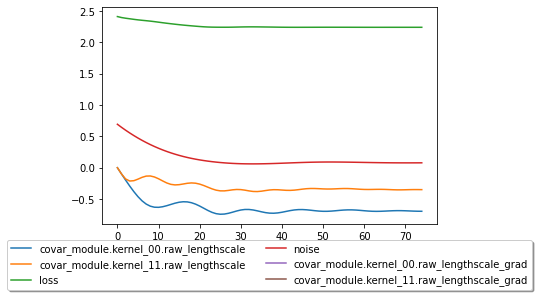

In [11]:
for param_key in param_dict:
    if param_key == 'task_noises':
        pass
    else:
        plt.plot(param_dict[param_key], label=param_key)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


In [12]:
print(likelihood.noise)
print(likelihood.task_noises)

tensor([0.0782], grad_fn=<AddBackward0>)
tensor([1.0000e-04, 1.0000e-04], grad_fn=<AddBackward0>)


In [13]:
A = matrix(QQ, 4, 4, (2,0,0.6065,0.6065,0,1,-0.6065,0.6065,0.6065,-0.6065,2,0,0.6065,0.6065,0,1))
L = A.cholesky()
L*L.transpose()

[  2.000000000000000?                    0  0.6065000000000000?  0.6065000000000000?]
[                   0                    1 -0.6065000000000000?  0.6065000000000000?]
[ 0.6065000000000000? -0.6065000000000000?   2.000000000000000?              0.?e-18]
[ 0.6065000000000000?  0.6065000000000000?              0.?e-18   1.000000000000000?]

In [14]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-2.5107], requires_grad=True))
('covar_module.kernel_00.raw_lengthscale', Parameter containing:
tensor([[-0.6949]], requires_grad=True))
('covar_module.kernel_11.raw_lengthscale', Parameter containing:
tensor([[-0.3514]], requires_grad=True))


In [15]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(120)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(-2), float(7), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


tensor([[1.0000e+00, 0.0000e+00, 9.7988e-01,  ..., 0.0000e+00, 6.4113e-22,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.7987e-12, 0.0000e+00,
         5.7607e-13],
        [9.7988e-01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 4.6041e-21,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.7987e-12, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         9.8833e-01],
        [6.4113e-22, 0.0000e+00, 4.6041e-21,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 5.7607e-13, 0.0000e+00,  ..., 9.8833e-01, 0.0000e+00,
         1.0000e+00]])
torch.return_types.eig(
eigenvalues=tensor([[ 1.5357e+01,  0.0000e+00],
        [ 1.1958e+01,  0.0000e+00],
        [ 1.0641e+01,  0.0000e+00],
        [ 1.2711e+01,  0.0000e+00],
        [ 8.7647e+00,  0.0000e+00],
        [ 6.6885e+00,  0.0000e+00],
        [ 9.2920e+00,  0.0000e+00],
        [ 4.7344e+00,  0.0000e+00],
        [ 3.1133e+00,  0.0000e+00],
        [ 6.0173e+00,  0.0000e+00],
        

Text(0.5, 1.0, 'Observed Values (Likelihood)')

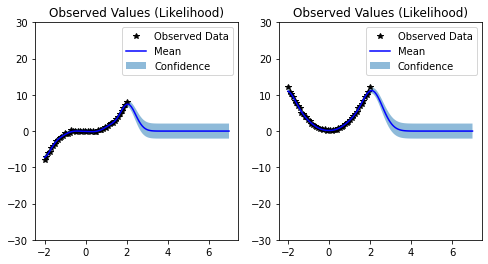

In [16]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(4)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-30, 30])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-30, 30])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


In [17]:
a = matrix(1, 2, (1, 2))
b = matrix(2, 2, (1, 2, 3, 4))
a*b

[ 7 10]

# Test Diffable SE Kernel

In [18]:
X = torch.tensor([int(1), int(2), int(3)])
X

tensor([1, 2, 3])

In [19]:
X = torch.linspace(float(-2), float(2), int(1))

In [20]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = float(SE.diff(x2).diff(x1).diff(x1).diff(x2)(int(v1), int(v2), lengthscale, variance))
cov_matr

[[3.0]]

In [21]:
print(SE)
print(SE.diff(x2))
#print(SE.diff(x1).diff(x2))
#print(SE.diff(x1).diff(x2).diff(x1))
#print(SE.diff(x1).diff(x2).diff(x1).diff(x2))
#float(SE.diff(x2).diff(x1)(float(1.), float(1.), 1, 1))

(x1, x2, l, sigma) |--> sigma^2*e^(-1/2*(x1 - x2)^2/l^2)
(x1, x2, l, sigma) |--> sigma^2*(x1 - x2)*e^(-1/2*(x1 - x2)^2/l^2)/l^2


In [22]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1^3 
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
left_poly = dx2
right_poly = 1
diffed_kernel2 = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate() + diffed_kernel2(X).evaluate()

TypeError: no canonical coercion from <class 'kernels.diffed_SE_kernel'> to Symbolic Ring

In [ ]:
def calc_cell_diff(L, M, R, context=None):
    len_M = np.shape(M)[0]
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
       map(list, itertools.zip_longest(*M, fillvalue=None)))
    for r_elem, row_M in zip(R, M_transpose):
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                if m_elem is not None:
                    temp = l_elem * m_elem*r_elem
                    #temp = l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
            else:
                if m_elem is not None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                    temp += l_elem * m_elem*r_elem
                    #temp += l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
    return temp.simplify_full()


In [ ]:
dimension = 3
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 0
col = 0
for row in range(dimension):
    for col in range(dimension):
        print((L*M*R)[row][col])
print("\n\n")
for i, (l, r) in enumerate(itertools.product(L.rows(), R.columns())):

    print(calc_cell_diff(l, M, r))
    print("\n")

In [ ]:
def calc_cell_diff_sage(L, M, R, context=None):
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
        map(list, itertools.zip_longest(*M, fillvalue=None)))
    # Every row in 'M' is combined with each elem of the row given in 'R'
    # Or: For each elemtn in row 'R' combine with 'row_M'
    for r_elem, row_M in zip(R, M_transpose):
        # Each element in L gets exactly one element in 'row_M' to multiply
        # Or: Combine each element in row_M with exactly one element in 'L'
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp = m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp = m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp = m_elem.diff(l_elem)
                else:
                    pass
            else:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp += m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp += m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp += m_elem.diff(l_elem)
                    
                else:
                    pass
    return temp

def diff_sage(matrix, left_matrix=None, right_matrix=None):
    # iterate left matrix by rows and right matrix by columns and call the
    # respective diff command of the kernels with the row/cols as params
    kernel = MatrixKernel(None)
    output_matrix = [[0 for i in range(np.shape(matrix)[1])] for j in range(np.shape(matrix)[0])]
    for i, (l, r) in enumerate(itertools.product(left_matrix.rows(), right_matrix.columns())):
        res = calc_cell_diff_sage(l, matrix, r, context=kernel)
        output_matrix[int(i/np.shape(matrix)[0])][
                    int(i % np.shape(matrix)[0])]  = res
    kernel.set_matrix(output_matrix)
    return output_matrix


In [ ]:
import pprint
L = matrix(2, 2, (x1, x1, 0, x1))
R = matrix(2, 2, (x2, 0, x2, x2))
x1, x2, l, sigma, l2, sigma2 = var('x1, x2, l, sigma, l2, sigma2')
lengthscale = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance = 1
lengthscale2 = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance2 = 1
SEKernelMatrix = [[sigma^2*exp(-(x1-x2)^2/(2*l^2)), sigma2^2*exp(-(x1-x2)^2/(2*l2^2))], [sigma2^2*exp(-(x1-x2)^2/(2*l2^2)), sigma^2*exp(-(x1-x2)^2/(2*l^2))]]
#diffed_SE_sage_matrix_kernel = diff_sage(SEKernelMatrix, left_matrix=L, right_matrix=R)
#pprint.pprint(diffed_SE_sage_matrix_kernel)
cov_matr = [[None for i in range(len(X)*len(SEKernelMatrix))] for j in range(len(X)*len(SEKernelMatrix))]
for i, (v1, v2) in enumerate(product(X, X)):
    for row in range(len(SEKernelMatrix)):
        for col in range(len(SEKernelMatrix)):
            # Blockwise
            #cov_matr[int(i/len(X))+row*len(X)][int(i%len(X))+col*len(X)] = SEKernelMatrix[row][col].substitute(x1=int(v1), x2=int(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2)
            # Interleaved
            text=f"x-pos: {int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row}" +\
            f" y-pos: {int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))}" + \
            f" x1, x2: {v1}, {v2}\n" +\
            f"(x1-x2)^2: {(v1-v2)**2}"+\
            f" exp((x1-x2)^2): {np.exp((v1-v2)**2)}\n"+\
            f"val: {float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))}"
            print(text)
            print("---")
            cov_matr[int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row][int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))] = float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))
cov_matr


In [ ]:
print(X)
print(torch.Tensor(cov_matr).eig())

In [ ]:
exp(-(-2-0.66)^2/(2))

In [ ]:

kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (dx1, dx1, 0, dx1))
R = matrix(2, 2, (dx2, 0, dx2, dx2))

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
covar_module = p.diff(left_matrix=L, right_matrix=R)

covar_x = covar_module(X)
covar_x.evaluate()

In [ ]:
matr = [[2, 0, -6*e^(-2), 1, e^(-1/2), -e^(-2)],
 [0, 2, 0, -e^(-1/2), 1, e^(-1/2)],
 [-6*e^(-2), 0, 2, -5*e^(-2), -e^(-1/2), 1],
 [1, e^(-1/2), -e^(-2), 1, 0, -3*e^(-2)],
 [-e^(-1/2), 1, e^(-1/2), 0, 1, 0],
 [-5*e^(-2), -e^(-1/2), 1, -3*e^(-2), 0, 1]]

matr = [[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

matr = torch.Tensor(matr)
import pprint
pprint.pprint(matr)
print(matr[0::3, 0::3])
H_x = 3
torch.vstack([torch.hstack([matr[k::H_x, l::H_x] for l in range(H_x)]) for k in range(H_x)])

In [ ]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [ ]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

In [ ]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [ ]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

In [ ]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

In [ ]:
prod([1,2,3])

In [ ]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

In [ ]:
a, b, c, d = var('a, b, c, d')
A = matrix(2,2, (a, b, c, d))
B = matrix(2, 2, (dx1, dx1, 0, dx1))
C = matrix(2, 2, (dx2, 0, dx2, dx2))
print(A)
print(B)
B*A

In [37]:
a, b, c, d, x, y, dx1 = var('a, b, c, d, x, y, dx1')
poly = (a*(2*(c+b)+a)+a)*y
#poly = a*b*dx1**3
print(type(poly))
#poly = 839840583*x^75
print(poly.degree(dx1))
print(poly.operands())
print([op.is_numeric() for op in poly.operands()])

<class 'sage.symbolic.expression.Expression'>
0
[(a + 2*b + 2*c)*a + a, y]
[False, False]


[autoreload of kernels failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/sage/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/sage/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/anaconda3/envs/sage/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/envs/sage/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 851, in exec_module
  File "<frozen importlib._bootstrap_external>", line 988, in get_code
  File "<frozen importlib._bootstrap_external>", line 918, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/andreas/Docu

In [57]:
left_poly = (a+1)*dx1**3
right_poly = (b+a)*dx2



"""
[
    [
        [Parameter containing:
tensor(1., requires_grad=True), tensor(1.), Parameter containing:
tensor(1., requires_grad=True), Parameter containing:
tensor(1., requires_grad=True)], 0, 0], 
    [
        [Parameter containing:
tensor(1., requires_grad=True), tensor(1.), tensor(1.)], 0, 1], 
    [
        [tensor(3.), Parameter containing:
tensor(1., requires_grad=True), Parameter containing:
tensor(1., requires_grad=True)], 3, 0], 
    [
        [tensor(3.), tensor(1.)], 3, 1]
]
"""




print(left_poly*right_poly)
(e**4*dx1**3).operands()


(a + b)*(a + 1)*dx1^3*dx2


[dx1^3, e^4]